In [1]:
# Imports
import os
import torch
import numpy as np
import re
from importlib import reload

# Training/Test Set Creation - to use later
from sklearn.model_selection import StratifiedShuffleSplit

# Dataset Creation
from collections import Counter
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize

# Model Training and Definition
from torch import nn
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
import trainutils_compound

# Create Training and Test Sets

## Load real edited videos

In [2]:
# Specify directories
frame_folder = "./data/frames"

# Construct X = folder names, y = the label
vf_list = os.listdir(frame_folder)

X_paths = [] # paths of segment folders
y = [] # designated label

for vf_folder in vf_list:
    
    # Create path to video
    vf_path = os.path.join(frame_folder, vf_folder)
    print("Current Video: "+ vf_folder)
    
    # Get individual segment folder
    segfolder_list = os.listdir(vf_path)
    
    # Check every segment folder
    for seg_folder in segfolder_list:
        
        #print(seg_folder)
        x_path = os.path.join(vf_path, seg_folder)
        #print(x_path)
        X_paths.append(x_path)
        
        # Extract class label from folder name
        label = int(seg_folder.split("_")[2])
        #print(label)
        y.append(label) # x 100 + 100
    
# create pytorch dataset class
class SyncDataset(Dataset):
    
    def __init__(self, X, y, transform=None):
        self.transform = transform
        self.X = X
        self.y = y
    
    # Returns length
    def __len__(self):
        return len(self.X)
    
    # Returns X feature array and y value
    def __getitem__(self, idx):
        
        # Load npz file
        npz_path = self.X[idx]+'/features.npz'
        data = np.load(npz_path)
        X_feat = data['feature_array']
        
        # apply transform
        if self.transform:
            X_tensor = self.transform(X_feat).squeeze().float()
        else:
            # Convert X to tensor
            X_tensor = torch.from_numpy(X_feat).float()
        
        return X_tensor, self.y[idx] # y_tensor
        
# Display video count and classes
len(X_paths), len(y), Counter(y)

Current Video: video1
Current Video: video2
Current Video: video3
Current Video: video4


(504,
 504,
 Counter({1: 54,
          2: 49,
          4: 50,
          5: 51,
          8: 52,
          9: 52,
          0: 48,
          3: 50,
          6: 48,
          7: 50}))

# Create Pytorch Dataset

In [3]:
# Split into training and test sets
splitter = StratifiedShuffleSplit(n_splits = 2, test_size = 0.1, random_state = 0)
train_set, test_set = next(splitter.split(X_paths, y))

# Training Set
train_X_paths = [X_paths[i] for i in train_set]
train_ys = [y[i] for i in train_set]
print("Training Set: ({0},{1})".format(len(train_X_paths), len(train_ys)))

# Test Set
test_X_paths = [X_paths[i] for i in test_set]
test_ys = [y[i] for i in test_set]
print("Test Set: ({0},{1})".format(len(test_X_paths), len(test_ys)))

Training Set: (453,453)
Test Set: (51,51)


In [4]:
# Set seeds for reproducibility
np.random.seed(4139)
torch.manual_seed(4139)

In [5]:
dataset = []
training_dataset = SyncDataset(X = train_X_paths, y = train_ys)
testing_dataset = SyncDataset(X = test_X_paths, y = test_ys)
for train_X, train_y in training_dataset:
    new_row = train_X.data.numpy()
    if len(dataset) == 0:
        dataset = new_row
    else:
        dataset = np.vstack((dataset,new_row))
# New: Test set
for test_X, test_y in testing_dataset:
    new_row = test_X.data.numpy()
    if len(dataset) == 0:
        dataset = new_row
    else:
        dataset = np.vstack((dataset,new_row))
saved_mean = np.mean(dataset, axis=0) 
saved_std = np.std(dataset, axis=0), 

class norm_with_saved(object):
    """
    Rescale so features are between 0 and 1 for each subject

    """
    def __call__(self, sample):
        # squeeze tensor
        sample = sample.squeeze()
        # normalize
        scaled_sample = (sample - saved_mean)/saved_std
        return scaled_sample

In [6]:
# Define Transformer - may need it for later, unused for now
transformer = transforms.Compose([
    norm_with_saved(),
    transforms.ToTensor(),
])

# Define Training Dataset 
training_dataset = SyncDataset(X = train_X_paths, y = train_ys, transform = transformer)

# Define Test Dataset
testing_dataset = SyncDataset(X = test_X_paths, y = test_ys, transform = transformer)

## Define Data Loader  
Data Loader for extracting batches from the Pytorch Dataset during model training

In [7]:
def batch_collater(batch):
    X_batch, y_batch = list(zip(*batch))
    
    # Separate batch into X and y
    X_batch = [x for x in X_batch if len(x) > 0]
    y_batch = [torch.tensor(y) for y, x in zip(y_batch, X_batch) if len(x) > 0]
    
    # Convert into tensors
    X_tensor = torch.stack(X_batch)
    y_tensor = torch.stack(y_batch).long()
    
    return X_tensor, y_tensor

In [8]:
# Specify batch size
batch_size = 30

training_loader = DataLoader(training_dataset, batch_size = batch_size, shuffle=True, collate_fn=batch_collater)
testing_loader = DataLoader(testing_dataset, batch_size = batch_size, shuffle=True, collate_fn=batch_collater)

# check shapes
for xb, yb in training_loader:
    print(xb.shape, yb.shape)
    break

for xb, yb in testing_loader:
    print(xb.shape, yb.shape)
    break

torch.Size([30, 20, 168]) torch.Size([30])
torch.Size([30, 20, 168]) torch.Size([30])


# Model Definition

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [10]:
class SyncRNN(nn.Module):
    
    def __init__(self, params_model):
        
        super(SyncRNN, self).__init__()
        
        # Import Model Parameters
        num_classes = params_model["num_classes"]
        rnn_hidden_size = params_model["rnn_hidden_size"]
        rnn_num_layers = params_model["rnn_num_layers"]
        num_features = 168
        batchsize = 1
        
        # Define Model Structure
        self.rnn = nn.LSTM(num_features, rnn_hidden_size, rnn_num_layers)
        self.fc1 = nn.Linear(rnn_hidden_size, num_classes)
        self.h0 = torch.zeros(rnn_num_layers, batchsize, rnn_hidden_size).cuda() # Initial hidden state
        self.c0 = torch.zeros(rnn_num_layers, batchsize, rnn_hidden_size).cuda() # Initial cell state
        
    def forward(self, x):
        
        # batch count, frame count, feature size
        batch_count, frame_count, feature_size = x.shape
        frame_idx = 0
        
        # Reshape the frame
        shaped_frame = x[:, frame_idx].view(batch_count, 1, feature_size)
        
        # Feed the first frame into the rnn
        output, (hn, cn) = self.rnn(shaped_frame, (self.h0, self.c0))
        
        # Feed the rest of the frames 
        for frame_idx in range(1, frame_count):
            shaped_frame = x[:, frame_idx].view(batch_count, 1, feature_size)
            output, (hn, cn) = self.rnn(shaped_frame, (hn, cn))
        
        output = self.fc1(output)
        
        return output

# Model Training  

Define loss function and optimizer to train the model

Table of tested params:

|  S/N  |  data  |  dr  |  layers  |  hidden_size  |  epochs  |   lr   |    loss     |  train_acc  |  test_acc | 
|-------|--------|------|----------|---------------|----------|--------|-------------|-------------|-----------|
|   1   |  real  |   0  |    1     |      300      |    100   |  3e-3  |   CE: 2.28  |      13     |     13    |
|   2   |  syn   |   0  |    1     |      300      |    30    |  3e-3  |   CE: 2.6   |      10     |     10    |
|   3   |  syn   |   0  |    1     |      300      |    30    |  0.1   |   CE: 2.45  |      10     |     10    |
|   4   |  syn   |   0  |    1     |      100      |    30    |  0.1   |   CE: 2.39  |      10     |     10    |
|   5   |  syn   |   0  |    1     |      100      |    200   |  0.1   |  MSE: 8.04  |      9.8    |     9.8   |
|   6   |  syn   |   0  |    1     |      300      |    200   |  0.1   |  MSE: 8.04  |      9.8    |     9.8   |
|   7   |  syn   |   0  |    1     |      100      |    200   |  3e-3  |  MSE: 8.04  |      9.8    |     9.8   |
|   8   |  real  |   0  |    1     |      100      |    200   |  3e-3  |  MSE: 20.7  |      9.8    |     9.8   |
|   9   |  real  |   0  |    1     |      100      |    200   |  3     |  MSE: 8.3   |      7.8    |     7.8   |
|   10  |r_inorm |   0  |    1     |      100      |    200   |  3     |  MSE: 8.3   |      9.8    |     9.8   |
|   11  |r_fnorm |   0  |    1     |      100      |    70    |  0.1   |  MSE: 8.3   |      9.8    |     9.8   |
|   12  |r_snorm |   0  |    1     |      100      |    70    |  0.1   |   CE: 1.5   |      9.8    |     9.8   |

In [11]:
# RNN Model Parameter
model_params = {
    "num_classes": 10,
    "rnn_num_layers": 1,
    "rnn_hidden_size": 100,
}
model = SyncRNN(model_params)
model = model.to(device)

In [12]:
# Test Model with dummy input
with torch.no_grad():
    x = torch.randn(1, 20, 168)
    y = model(x.to(device))
    print(y.shape) # should be [1,10]

torch.Size([1, 1, 10])


In [13]:
# Define Loss Function
ce_lossfn = nn.CrossEntropyLoss(reduction="sum")

# Define Optimizer (Adam)
ce_optimizer = optim.Adam(model.parameters(), lr = 0.2) 

# Define LR Scheduler
ce_lr_scheduler = ReduceLROnPlateau(ce_optimizer, mode='min', factor=0.7, patience = 5, verbose=1)
os.makedirs("./models", exist_ok=True)

# Define Training Parameters - tweak this
train_params = {
    "num_epochs": 200,
    "ce_optimizer": ce_optimizer,
    "ce_lossfn": ce_lossfn,
    "penalty_weight": 0.3, # 70% CE, 30% class penalty
    "training_loader": training_loader,
    "testing_loader": testing_loader,
    "ce_lr_scheduler": ce_lr_scheduler,
    "weights_path": "./models/weights_norm_compound.pt",
}

In [14]:
trained_model, loss_hist, metric_hist = trainutils_compound.train_compound_model(model, train_params)

Epoch 0/199, current_lr=0.2



Saved best model weights
Train Loss: 2.644558, Dev Loss: 3.677006, Accuracy: 15.69
----------
Epoch 1/199, current_lr=0.2



Saved best model weights
Train Loss: 2.736357, Dev Loss: 3.536460, Accuracy: 13.73
----------
Epoch 2/199, current_lr=0.2



Train Loss: 2.517682, Dev Loss: 3.714482, Accuracy: 19.61
----------
Epoch 3/199, current_lr=0.2



Train Loss: 2.506889, Dev Loss: 3.811652, Accuracy: 17.65
----------
Epoch 4/199, current_lr=0.2



Saved best model weights
Train Loss: 2.573161, Dev Loss: 3.389833, Accuracy: 13.73
----------
Epoch 5/199, current_lr=0.2



Train Loss: 2.300191, Dev Loss: 3.979491, Accuracy: 11.76
----------
Epoch 6/199, current_lr=0.2



Train Loss: 2.335170, Dev Loss: 3.827361, Accuracy: 7.84
----------
Epoch 7/199, current_lr=0.2



Train Loss: 2.283250, Dev Loss: 3.718914, Accuracy: 15.69
----------
Epoch 8/199, current_lr=0.2



Train Loss: 2.317161, Dev Loss: 3.450568, Accuracy: 7.84
----------
Epoch 9/199, current_lr=0.2



Train Loss: 2.245326, Dev Loss: 3.421136, Accuracy: 19.61
----------
Epoch 10/199, current_lr=0.2



Epoch    11: reducing learning rate of group 0 to 1.4000e-01.
Loading best model weights
Train Loss: 2.432376, Dev Loss: 3.821729, Accuracy: 15.69
----------
Epoch 11/199, current_lr=0.13999999999999999



Train Loss: 2.147982, Dev Loss: 3.766689, Accuracy: 11.76
----------
Epoch 12/199, current_lr=0.13999999999999999



Train Loss: 1.999737, Dev Loss: 3.653929, Accuracy: 9.80
----------
Epoch 13/199, current_lr=0.13999999999999999



Saved best model weights
Train Loss: 2.010745, Dev Loss: 2.940366, Accuracy: 15.69
----------
Epoch 14/199, current_lr=0.13999999999999999



Train Loss: 1.913043, Dev Loss: 3.019525, Accuracy: 17.65
----------
Epoch 15/199, current_lr=0.13999999999999999



Train Loss: 1.941561, Dev Loss: 3.307586, Accuracy: 3.92
----------
Epoch 16/199, current_lr=0.13999999999999999



Train Loss: 1.897436, Dev Loss: 3.376522, Accuracy: 11.76
----------
Epoch 17/199, current_lr=0.13999999999999999



Train Loss: 1.925312, Dev Loss: 3.175309, Accuracy: 11.76
----------
Epoch 18/199, current_lr=0.13999999999999999



Train Loss: 1.928377, Dev Loss: 3.484006, Accuracy: 9.80
----------
Epoch 19/199, current_lr=0.13999999999999999



Epoch    20: reducing learning rate of group 0 to 9.8000e-02.
Loading best model weights
Train Loss: 1.879863, Dev Loss: 3.305864, Accuracy: 9.80
----------
Epoch 20/199, current_lr=0.09799999999999999



Train Loss: 1.873903, Dev Loss: 3.212335, Accuracy: 13.73
----------
Epoch 21/199, current_lr=0.09799999999999999



Train Loss: 1.688250, Dev Loss: 3.059179, Accuracy: 9.80
----------
Epoch 22/199, current_lr=0.09799999999999999



Saved best model weights
Train Loss: 1.649747, Dev Loss: 2.770987, Accuracy: 15.69
----------
Epoch 23/199, current_lr=0.09799999999999999



Train Loss: 1.629886, Dev Loss: 2.929030, Accuracy: 7.84
----------
Epoch 24/199, current_lr=0.09799999999999999



Train Loss: 1.680273, Dev Loss: 2.884933, Accuracy: 15.69
----------
Epoch 25/199, current_lr=0.09799999999999999



Train Loss: 1.651307, Dev Loss: 3.141265, Accuracy: 9.80
----------
Epoch 26/199, current_lr=0.09799999999999999



Train Loss: 1.605688, Dev Loss: 2.961157, Accuracy: 7.84
----------
Epoch 27/199, current_lr=0.09799999999999999



Train Loss: 1.584976, Dev Loss: 2.780495, Accuracy: 13.73
----------
Epoch 28/199, current_lr=0.09799999999999999



Epoch    29: reducing learning rate of group 0 to 6.8600e-02.
Loading best model weights
Train Loss: 1.656377, Dev Loss: 3.303803, Accuracy: 9.80
----------
Epoch 29/199, current_lr=0.0686



Train Loss: 1.548843, Dev Loss: 3.031740, Accuracy: 11.76
----------
Epoch 30/199, current_lr=0.0686



Train Loss: 1.587011, Dev Loss: 3.156421, Accuracy: 3.92
----------
Epoch 31/199, current_lr=0.0686



Train Loss: 1.428696, Dev Loss: 2.998850, Accuracy: 7.84
----------
Epoch 32/199, current_lr=0.0686



Train Loss: 1.488231, Dev Loss: 3.089536, Accuracy: 3.92
----------
Epoch 33/199, current_lr=0.0686



Train Loss: 1.485870, Dev Loss: 3.022907, Accuracy: 7.84
----------
Epoch 34/199, current_lr=0.0686



Epoch    35: reducing learning rate of group 0 to 4.8020e-02.
Loading best model weights
Train Loss: 1.434091, Dev Loss: 3.089336, Accuracy: 7.84
----------
Epoch 35/199, current_lr=0.04801999999999999



Train Loss: 1.542745, Dev Loss: 2.894386, Accuracy: 9.80
----------
Epoch 36/199, current_lr=0.04801999999999999



Train Loss: 1.467901, Dev Loss: 3.025842, Accuracy: 7.84
----------
Epoch 37/199, current_lr=0.04801999999999999



Saved best model weights
Train Loss: 1.457924, Dev Loss: 2.569499, Accuracy: 11.76
----------
Epoch 38/199, current_lr=0.04801999999999999



Train Loss: 1.405046, Dev Loss: 2.885433, Accuracy: 11.76
----------
Epoch 39/199, current_lr=0.04801999999999999



Train Loss: 1.422423, Dev Loss: 2.823027, Accuracy: 7.84
----------
Epoch 40/199, current_lr=0.04801999999999999



Train Loss: 1.313259, Dev Loss: 2.777421, Accuracy: 9.80
----------
Epoch 41/199, current_lr=0.04801999999999999



Train Loss: 1.362718, Dev Loss: 2.884607, Accuracy: 13.73
----------
Epoch 42/199, current_lr=0.04801999999999999



Saved best model weights
Train Loss: 1.343938, Dev Loss: 2.559617, Accuracy: 19.61
----------
Epoch 43/199, current_lr=0.04801999999999999



Saved best model weights
Train Loss: 1.341210, Dev Loss: 2.510275, Accuracy: 13.73
----------
Epoch 44/199, current_lr=0.04801999999999999



Train Loss: 1.306707, Dev Loss: 2.742710, Accuracy: 13.73
----------
Epoch 45/199, current_lr=0.04801999999999999



Train Loss: 1.393385, Dev Loss: 2.630792, Accuracy: 17.65
----------
Epoch 46/199, current_lr=0.04801999999999999



Train Loss: 1.294128, Dev Loss: 2.666535, Accuracy: 13.73
----------
Epoch 47/199, current_lr=0.04801999999999999



Train Loss: 1.329094, Dev Loss: 2.811787, Accuracy: 3.92
----------
Epoch 48/199, current_lr=0.04801999999999999



Train Loss: 1.317803, Dev Loss: 2.830482, Accuracy: 13.73
----------
Epoch 49/199, current_lr=0.04801999999999999



Epoch    50: reducing learning rate of group 0 to 3.3614e-02.
Loading best model weights
Train Loss: 1.266359, Dev Loss: 2.881900, Accuracy: 11.76
----------
Epoch 50/199, current_lr=0.03361399999999999



Train Loss: 1.329555, Dev Loss: 2.521097, Accuracy: 13.73
----------
Epoch 51/199, current_lr=0.03361399999999999



Train Loss: 1.274342, Dev Loss: 2.726885, Accuracy: 17.65
----------
Epoch 52/199, current_lr=0.03361399999999999



Train Loss: 1.245535, Dev Loss: 3.055550, Accuracy: 9.80
----------
Epoch 53/199, current_lr=0.03361399999999999



Train Loss: 1.187704, Dev Loss: 2.706616, Accuracy: 9.80
----------
Epoch 54/199, current_lr=0.03361399999999999



Train Loss: 1.256280, Dev Loss: 2.697065, Accuracy: 13.73
----------
Epoch 55/199, current_lr=0.03361399999999999



Epoch    56: reducing learning rate of group 0 to 2.3530e-02.
Loading best model weights
Train Loss: 1.228900, Dev Loss: 2.681250, Accuracy: 9.80
----------
Epoch 56/199, current_lr=0.023529799999999993



Train Loss: 1.275670, Dev Loss: 2.916780, Accuracy: 9.80
----------
Epoch 57/199, current_lr=0.023529799999999993



Train Loss: 1.235715, Dev Loss: 2.516509, Accuracy: 19.61
----------
Epoch 58/199, current_lr=0.023529799999999993



Train Loss: 1.198267, Dev Loss: 2.677084, Accuracy: 13.73
----------
Epoch 59/199, current_lr=0.023529799999999993



Train Loss: 1.208635, Dev Loss: 2.713828, Accuracy: 17.65
----------
Epoch 60/199, current_lr=0.023529799999999993



Train Loss: 1.213352, Dev Loss: 2.733357, Accuracy: 11.76
----------
Epoch 61/199, current_lr=0.023529799999999993



Epoch    62: reducing learning rate of group 0 to 1.6471e-02.
Loading best model weights
Train Loss: 1.195876, Dev Loss: 2.883252, Accuracy: 3.92
----------
Epoch 62/199, current_lr=0.016470859999999993



Train Loss: 1.264841, Dev Loss: 2.880911, Accuracy: 15.69
----------
Epoch 63/199, current_lr=0.016470859999999993



Train Loss: 1.209279, Dev Loss: 2.902645, Accuracy: 13.73
----------
Epoch 64/199, current_lr=0.016470859999999993



Train Loss: 1.258152, Dev Loss: 2.655138, Accuracy: 11.76
----------
Epoch 65/199, current_lr=0.016470859999999993



Train Loss: 1.185782, Dev Loss: 2.610595, Accuracy: 17.65
----------
Epoch 66/199, current_lr=0.016470859999999993



Train Loss: 1.175555, Dev Loss: 2.723490, Accuracy: 11.76
----------
Epoch 67/199, current_lr=0.016470859999999993



Epoch    68: reducing learning rate of group 0 to 1.1530e-02.
Loading best model weights
Train Loss: 1.146475, Dev Loss: 2.621109, Accuracy: 19.61
----------
Epoch 68/199, current_lr=0.011529601999999995



Train Loss: 1.305642, Dev Loss: 2.625155, Accuracy: 11.76
----------
Epoch 69/199, current_lr=0.011529601999999995



Train Loss: 1.212800, Dev Loss: 2.867286, Accuracy: 11.76
----------
Epoch 70/199, current_lr=0.011529601999999995



Train Loss: 1.240215, Dev Loss: 2.643179, Accuracy: 11.76
----------
Epoch 71/199, current_lr=0.011529601999999995



Train Loss: 1.190830, Dev Loss: 2.771747, Accuracy: 17.65
----------
Epoch 72/199, current_lr=0.011529601999999995



Train Loss: 1.126992, Dev Loss: 2.580427, Accuracy: 11.76
----------
Epoch 73/199, current_lr=0.011529601999999995



Epoch    74: reducing learning rate of group 0 to 8.0707e-03.
Loading best model weights
Train Loss: 1.196683, Dev Loss: 2.695872, Accuracy: 9.80
----------
Epoch 74/199, current_lr=0.008070721399999996



Train Loss: 1.218999, Dev Loss: 2.703920, Accuracy: 17.65
----------
Epoch 75/199, current_lr=0.008070721399999996



Train Loss: 1.222123, Dev Loss: 2.790252, Accuracy: 11.76
----------
Epoch 76/199, current_lr=0.008070721399999996



Train Loss: 1.227180, Dev Loss: 2.690380, Accuracy: 15.69
----------
Epoch 77/199, current_lr=0.008070721399999996



Train Loss: 1.213105, Dev Loss: 2.555081, Accuracy: 13.73
----------
Epoch 78/199, current_lr=0.008070721399999996



Train Loss: 1.197105, Dev Loss: 2.714177, Accuracy: 19.61
----------
Epoch 79/199, current_lr=0.008070721399999996



Epoch    80: reducing learning rate of group 0 to 5.6495e-03.
Loading best model weights
Train Loss: 1.163039, Dev Loss: 2.779308, Accuracy: 5.88
----------
Epoch 80/199, current_lr=0.005649504979999997



Train Loss: 1.252771, Dev Loss: 2.594658, Accuracy: 11.76
----------
Epoch 81/199, current_lr=0.005649504979999997



Train Loss: 1.265098, Dev Loss: 2.915983, Accuracy: 7.84
----------
Epoch 82/199, current_lr=0.005649504979999997



Train Loss: 1.206057, Dev Loss: 2.544124, Accuracy: 19.61
----------
Epoch 83/199, current_lr=0.005649504979999997



Train Loss: 1.211512, Dev Loss: 2.712935, Accuracy: 17.65
----------
Epoch 84/199, current_lr=0.005649504979999997



Train Loss: 1.190728, Dev Loss: 2.678848, Accuracy: 13.73
----------
Epoch 85/199, current_lr=0.005649504979999997



Epoch    86: reducing learning rate of group 0 to 3.9547e-03.
Loading best model weights
Train Loss: 1.198187, Dev Loss: 2.788166, Accuracy: 15.69
----------
Epoch 86/199, current_lr=0.003954653485999997



Train Loss: 1.254924, Dev Loss: 2.690700, Accuracy: 9.80
----------
Epoch 87/199, current_lr=0.003954653485999997



Train Loss: 1.264993, Dev Loss: 2.689348, Accuracy: 15.69
----------
Epoch 88/199, current_lr=0.003954653485999997



Train Loss: 1.196355, Dev Loss: 2.516928, Accuracy: 13.73
----------
Epoch 89/199, current_lr=0.003954653485999997



Train Loss: 1.190484, Dev Loss: 2.865961, Accuracy: 5.88
----------
Epoch 90/199, current_lr=0.003954653485999997



Train Loss: 1.191019, Dev Loss: 2.794403, Accuracy: 13.73
----------
Epoch 91/199, current_lr=0.003954653485999997



Saved best model weights
Train Loss: 1.194192, Dev Loss: 2.478875, Accuracy: 15.69
----------
Epoch 92/199, current_lr=0.003954653485999997



Train Loss: 1.208057, Dev Loss: 2.773043, Accuracy: 13.73
----------
Epoch 93/199, current_lr=0.003954653485999997



Train Loss: 1.170170, Dev Loss: 2.784076, Accuracy: 13.73
----------
Epoch 94/199, current_lr=0.003954653485999997



Saved best model weights
Train Loss: 1.174730, Dev Loss: 2.419734, Accuracy: 23.53
----------
Epoch 95/199, current_lr=0.003954653485999997



Train Loss: 1.130131, Dev Loss: 2.619232, Accuracy: 9.80
----------
Epoch 96/199, current_lr=0.003954653485999997



Train Loss: 1.162128, Dev Loss: 2.697967, Accuracy: 21.57
----------
Epoch 97/199, current_lr=0.003954653485999997



Saved best model weights
Train Loss: 1.120830, Dev Loss: 2.411729, Accuracy: 11.76
----------
Epoch 98/199, current_lr=0.003954653485999997



Train Loss: 1.172642, Dev Loss: 2.736162, Accuracy: 17.65
----------
Epoch 99/199, current_lr=0.003954653485999997



Train Loss: 1.123063, Dev Loss: 2.571808, Accuracy: 9.80
----------
Epoch 100/199, current_lr=0.003954653485999997



Train Loss: 1.110626, Dev Loss: 2.732276, Accuracy: 15.69
----------
Epoch 101/199, current_lr=0.003954653485999997



Train Loss: 1.138867, Dev Loss: 2.555229, Accuracy: 17.65
----------
Epoch 102/199, current_lr=0.003954653485999997



Train Loss: 1.130193, Dev Loss: 2.747197, Accuracy: 17.65
----------
Epoch 103/199, current_lr=0.003954653485999997



Epoch   104: reducing learning rate of group 0 to 2.7683e-03.
Loading best model weights
Train Loss: 1.138362, Dev Loss: 2.706972, Accuracy: 13.73
----------
Epoch 104/199, current_lr=0.0027682574401999976



Train Loss: 1.143069, Dev Loss: 2.818309, Accuracy: 7.84
----------
Epoch 105/199, current_lr=0.0027682574401999976



Train Loss: 1.147606, Dev Loss: 2.720181, Accuracy: 13.73
----------
Epoch 106/199, current_lr=0.0027682574401999976



Train Loss: 1.174534, Dev Loss: 2.675767, Accuracy: 19.61
----------
Epoch 107/199, current_lr=0.0027682574401999976



Train Loss: 1.159779, Dev Loss: 2.527144, Accuracy: 19.61
----------
Epoch 108/199, current_lr=0.0027682574401999976



Train Loss: 1.119622, Dev Loss: 2.417355, Accuracy: 11.76
----------
Epoch 109/199, current_lr=0.0027682574401999976



Epoch   110: reducing learning rate of group 0 to 1.9378e-03.
Loading best model weights
Train Loss: 1.134543, Dev Loss: 2.597283, Accuracy: 15.69
----------
Epoch 110/199, current_lr=0.0019377802081399981



Train Loss: 1.150303, Dev Loss: 2.681029, Accuracy: 9.80
----------
Epoch 111/199, current_lr=0.0019377802081399981



Train Loss: 1.106910, Dev Loss: 2.460827, Accuracy: 17.65
----------
Epoch 112/199, current_lr=0.0019377802081399981



Train Loss: 1.129470, Dev Loss: 2.844711, Accuracy: 9.80
----------
Epoch 113/199, current_lr=0.0019377802081399981



Train Loss: 1.118867, Dev Loss: 2.502302, Accuracy: 15.69
----------
Epoch 114/199, current_lr=0.0019377802081399981



Train Loss: 1.161605, Dev Loss: 2.604646, Accuracy: 11.76
----------
Epoch 115/199, current_lr=0.0019377802081399981



Epoch   116: reducing learning rate of group 0 to 1.3564e-03.
Loading best model weights
Train Loss: 1.121417, Dev Loss: 2.607794, Accuracy: 21.57
----------
Epoch 116/199, current_lr=0.0013564461456979987



Train Loss: 1.181095, Dev Loss: 2.453655, Accuracy: 25.49
----------
Epoch 117/199, current_lr=0.0013564461456979987



Train Loss: 1.134307, Dev Loss: 2.740531, Accuracy: 13.73
----------
Epoch 118/199, current_lr=0.0013564461456979987



Train Loss: 1.094038, Dev Loss: 2.834943, Accuracy: 21.57
----------
Epoch 119/199, current_lr=0.0013564461456979987



Train Loss: 1.132162, Dev Loss: 2.780780, Accuracy: 11.76
----------
Epoch 120/199, current_lr=0.0013564461456979987



Train Loss: 1.138945, Dev Loss: 2.743974, Accuracy: 15.69
----------
Epoch 121/199, current_lr=0.0013564461456979987



Epoch   122: reducing learning rate of group 0 to 9.4951e-04.
Loading best model weights
Train Loss: 1.148345, Dev Loss: 2.607728, Accuracy: 17.65
----------
Epoch 122/199, current_lr=0.000949512301988599



Train Loss: 1.161249, Dev Loss: 2.834726, Accuracy: 9.80
----------
Epoch 123/199, current_lr=0.000949512301988599



Train Loss: 1.147398, Dev Loss: 2.528604, Accuracy: 7.84
----------
Epoch 124/199, current_lr=0.000949512301988599



Train Loss: 1.161278, Dev Loss: 2.471040, Accuracy: 15.69
----------
Epoch 125/199, current_lr=0.000949512301988599



Train Loss: 1.103259, Dev Loss: 2.882482, Accuracy: 13.73
----------
Epoch 126/199, current_lr=0.000949512301988599



Train Loss: 1.115666, Dev Loss: 2.711983, Accuracy: 7.84
----------
Epoch 127/199, current_lr=0.000949512301988599



Epoch   128: reducing learning rate of group 0 to 6.6466e-04.
Loading best model weights
Train Loss: 1.128993, Dev Loss: 2.745474, Accuracy: 11.76
----------
Epoch 128/199, current_lr=0.0006646586113920192



Train Loss: 1.171909, Dev Loss: 2.724767, Accuracy: 11.76
----------
Epoch 129/199, current_lr=0.0006646586113920192



Train Loss: 1.181095, Dev Loss: 2.790441, Accuracy: 11.76
----------
Epoch 130/199, current_lr=0.0006646586113920192



Train Loss: 1.184234, Dev Loss: 2.695073, Accuracy: 13.73
----------
Epoch 131/199, current_lr=0.0006646586113920192



Train Loss: 1.139193, Dev Loss: 2.820208, Accuracy: 7.84
----------
Epoch 132/199, current_lr=0.0006646586113920192



Train Loss: 1.161204, Dev Loss: 2.660618, Accuracy: 11.76
----------
Epoch 133/199, current_lr=0.0006646586113920192



Epoch   134: reducing learning rate of group 0 to 4.6526e-04.
Loading best model weights
Train Loss: 1.141407, Dev Loss: 2.582167, Accuracy: 11.76
----------
Epoch 134/199, current_lr=0.0004652610279744134



Train Loss: 1.122738, Dev Loss: 2.737223, Accuracy: 11.76
----------
Epoch 135/199, current_lr=0.0004652610279744134



Train Loss: 1.121385, Dev Loss: 2.649885, Accuracy: 15.69
----------
Epoch 136/199, current_lr=0.0004652610279744134



Train Loss: 1.139833, Dev Loss: 2.556304, Accuracy: 9.80
----------
Epoch 137/199, current_lr=0.0004652610279744134



Train Loss: 1.152317, Dev Loss: 2.723718, Accuracy: 11.76
----------
Epoch 138/199, current_lr=0.0004652610279744134



Train Loss: 1.167967, Dev Loss: 2.632374, Accuracy: 7.84
----------
Epoch 139/199, current_lr=0.0004652610279744134



Epoch   140: reducing learning rate of group 0 to 3.2568e-04.
Loading best model weights
Train Loss: 1.129827, Dev Loss: 2.606261, Accuracy: 11.76
----------
Epoch 140/199, current_lr=0.0003256827195820893



Train Loss: 1.159723, Dev Loss: 2.585220, Accuracy: 19.61
----------
Epoch 141/199, current_lr=0.0003256827195820893



Train Loss: 1.150788, Dev Loss: 2.936967, Accuracy: 17.65
----------
Epoch 142/199, current_lr=0.0003256827195820893



Train Loss: 1.139438, Dev Loss: 2.490583, Accuracy: 21.57
----------
Epoch 143/199, current_lr=0.0003256827195820893



Train Loss: 1.103516, Dev Loss: 2.746455, Accuracy: 15.69
----------
Epoch 144/199, current_lr=0.0003256827195820893



Train Loss: 1.149728, Dev Loss: 2.651115, Accuracy: 19.61
----------
Epoch 145/199, current_lr=0.0003256827195820893



Epoch   146: reducing learning rate of group 0 to 2.2798e-04.
Loading best model weights
Train Loss: 1.168686, Dev Loss: 2.739771, Accuracy: 9.80
----------
Epoch 146/199, current_lr=0.00022797790370746252



Train Loss: 1.141500, Dev Loss: 2.484167, Accuracy: 17.65
----------
Epoch 147/199, current_lr=0.00022797790370746252



Train Loss: 1.126114, Dev Loss: 2.614098, Accuracy: 15.69
----------
Epoch 148/199, current_lr=0.00022797790370746252



Train Loss: 1.117763, Dev Loss: 2.660147, Accuracy: 11.76
----------
Epoch 149/199, current_lr=0.00022797790370746252



Train Loss: 1.167628, Dev Loss: 2.756491, Accuracy: 17.65
----------
Epoch 150/199, current_lr=0.00022797790370746252



Train Loss: 1.174876, Dev Loss: 2.687423, Accuracy: 11.76
----------
Epoch 151/199, current_lr=0.00022797790370746252



Epoch   152: reducing learning rate of group 0 to 1.5958e-04.
Loading best model weights
Train Loss: 1.161093, Dev Loss: 2.487662, Accuracy: 11.76
----------
Epoch 152/199, current_lr=0.00015958453259522375



Train Loss: 1.149221, Dev Loss: 2.710981, Accuracy: 15.69
----------
Epoch 153/199, current_lr=0.00015958453259522375



Train Loss: 1.173191, Dev Loss: 2.626006, Accuracy: 15.69
----------
Epoch 154/199, current_lr=0.00015958453259522375



Train Loss: 1.128300, Dev Loss: 2.718681, Accuracy: 13.73
----------
Epoch 155/199, current_lr=0.00015958453259522375



Train Loss: 1.144038, Dev Loss: 2.698575, Accuracy: 13.73
----------
Epoch 156/199, current_lr=0.00015958453259522375



Train Loss: 1.137163, Dev Loss: 2.599373, Accuracy: 17.65
----------
Epoch 157/199, current_lr=0.00015958453259522375



Epoch   158: reducing learning rate of group 0 to 1.1171e-04.
Loading best model weights
Train Loss: 1.141184, Dev Loss: 2.511535, Accuracy: 19.61
----------
Epoch 158/199, current_lr=0.00011170917281665661



Train Loss: 1.151171, Dev Loss: 2.709154, Accuracy: 13.73
----------
Epoch 159/199, current_lr=0.00011170917281665661



Train Loss: 1.147193, Dev Loss: 2.506666, Accuracy: 15.69
----------
Epoch 160/199, current_lr=0.00011170917281665661



Train Loss: 1.154868, Dev Loss: 2.528906, Accuracy: 11.76
----------
Epoch 161/199, current_lr=0.00011170917281665661



Train Loss: 1.139259, Dev Loss: 2.672077, Accuracy: 5.88
----------
Epoch 162/199, current_lr=0.00011170917281665661



Train Loss: 1.141342, Dev Loss: 2.681128, Accuracy: 17.65
----------
Epoch 163/199, current_lr=0.00011170917281665661



Epoch   164: reducing learning rate of group 0 to 7.8196e-05.
Loading best model weights
Train Loss: 1.171325, Dev Loss: 2.600268, Accuracy: 17.65
----------
Epoch 164/199, current_lr=7.819642097165963e-05



Train Loss: 1.150336, Dev Loss: 2.675558, Accuracy: 13.73
----------
Epoch 165/199, current_lr=7.819642097165963e-05



Train Loss: 1.159080, Dev Loss: 2.948218, Accuracy: 15.69
----------
Epoch 166/199, current_lr=7.819642097165963e-05



Train Loss: 1.148101, Dev Loss: 2.657976, Accuracy: 9.80
----------
Epoch 167/199, current_lr=7.819642097165963e-05



Train Loss: 1.102771, Dev Loss: 2.651752, Accuracy: 9.80
----------
Epoch 168/199, current_lr=7.819642097165963e-05



Train Loss: 1.156830, Dev Loss: 2.664430, Accuracy: 13.73
----------
Epoch 169/199, current_lr=7.819642097165963e-05



Epoch   170: reducing learning rate of group 0 to 5.4737e-05.
Loading best model weights
Train Loss: 1.163139, Dev Loss: 2.664524, Accuracy: 13.73
----------
Epoch 170/199, current_lr=5.473749468016174e-05



Train Loss: 1.154763, Dev Loss: 2.561115, Accuracy: 15.69
----------
Epoch 171/199, current_lr=5.473749468016174e-05



Train Loss: 1.117171, Dev Loss: 2.627225, Accuracy: 17.65
----------
Epoch 172/199, current_lr=5.473749468016174e-05



Train Loss: 1.142161, Dev Loss: 2.556478, Accuracy: 19.61
----------
Epoch 173/199, current_lr=5.473749468016174e-05



Train Loss: 1.151791, Dev Loss: 2.667794, Accuracy: 11.76
----------
Epoch 174/199, current_lr=5.473749468016174e-05



Train Loss: 1.157129, Dev Loss: 2.699547, Accuracy: 13.73
----------
Epoch 175/199, current_lr=5.473749468016174e-05



Epoch   176: reducing learning rate of group 0 to 3.8316e-05.
Loading best model weights
Train Loss: 1.147816, Dev Loss: 2.531007, Accuracy: 21.57
----------
Epoch 176/199, current_lr=3.8316246276113215e-05



Train Loss: 1.119850, Dev Loss: 2.661722, Accuracy: 9.80
----------
Epoch 177/199, current_lr=3.8316246276113215e-05



Train Loss: 1.171658, Dev Loss: 2.728798, Accuracy: 13.73
----------
Epoch 178/199, current_lr=3.8316246276113215e-05



Train Loss: 1.127378, Dev Loss: 2.738535, Accuracy: 17.65
----------
Epoch 179/199, current_lr=3.8316246276113215e-05



Train Loss: 1.123207, Dev Loss: 2.771369, Accuracy: 21.57
----------
Epoch 180/199, current_lr=3.8316246276113215e-05



Train Loss: 1.126495, Dev Loss: 2.676715, Accuracy: 11.76
----------
Epoch 181/199, current_lr=3.8316246276113215e-05



Epoch   182: reducing learning rate of group 0 to 2.6821e-05.
Loading best model weights
Train Loss: 1.169375, Dev Loss: 2.832879, Accuracy: 15.69
----------
Epoch 182/199, current_lr=2.6821372393279248e-05



Train Loss: 1.137433, Dev Loss: 2.484055, Accuracy: 11.76
----------
Epoch 183/199, current_lr=2.6821372393279248e-05



Train Loss: 1.174794, Dev Loss: 2.578714, Accuracy: 17.65
----------
Epoch 184/199, current_lr=2.6821372393279248e-05



Train Loss: 1.184545, Dev Loss: 2.744475, Accuracy: 15.69
----------
Epoch 185/199, current_lr=2.6821372393279248e-05



Train Loss: 1.150313, Dev Loss: 2.626114, Accuracy: 15.69
----------
Epoch 186/199, current_lr=2.6821372393279248e-05



Train Loss: 1.151823, Dev Loss: 2.787556, Accuracy: 15.69
----------
Epoch 187/199, current_lr=2.6821372393279248e-05



Epoch   188: reducing learning rate of group 0 to 1.8775e-05.
Loading best model weights
Train Loss: 1.139172, Dev Loss: 2.598217, Accuracy: 15.69
----------
Epoch 188/199, current_lr=1.8774960675295472e-05



Train Loss: 1.163626, Dev Loss: 2.717150, Accuracy: 15.69
----------
Epoch 189/199, current_lr=1.8774960675295472e-05



Train Loss: 1.154160, Dev Loss: 2.607659, Accuracy: 13.73
----------
Epoch 190/199, current_lr=1.8774960675295472e-05



Train Loss: 1.141878, Dev Loss: 2.609835, Accuracy: 17.65
----------
Epoch 191/199, current_lr=1.8774960675295472e-05



Train Loss: 1.144726, Dev Loss: 2.674022, Accuracy: 17.65
----------
Epoch 192/199, current_lr=1.8774960675295472e-05



Train Loss: 1.177556, Dev Loss: 2.564900, Accuracy: 11.76
----------
Epoch 193/199, current_lr=1.8774960675295472e-05



Epoch   194: reducing learning rate of group 0 to 1.3142e-05.
Loading best model weights
Train Loss: 1.135208, Dev Loss: 2.620983, Accuracy: 13.73
----------
Epoch 194/199, current_lr=1.314247247270683e-05



Train Loss: 1.114927, Dev Loss: 2.608274, Accuracy: 11.76
----------
Epoch 195/199, current_lr=1.314247247270683e-05



Train Loss: 1.134608, Dev Loss: 2.770279, Accuracy: 17.65
----------
Epoch 196/199, current_lr=1.314247247270683e-05



Train Loss: 1.115497, Dev Loss: 2.912156, Accuracy: 15.69
----------
Epoch 197/199, current_lr=1.314247247270683e-05



Train Loss: 1.124609, Dev Loss: 2.682182, Accuracy: 17.65
----------
Epoch 198/199, current_lr=1.314247247270683e-05



Train Loss: 1.184306, Dev Loss: 2.767310, Accuracy: 13.73
----------
Epoch 199/199, current_lr=1.314247247270683e-05



Epoch   200: reducing learning rate of group 0 to 9.1997e-06.
Loading best model weights
Train Loss: 1.118488, Dev Loss: 2.535295, Accuracy: 11.76
----------


In [15]:
# check output
for xb, yb in training_loader:
    with torch.no_grad():
        x = xb
        y = model(x.to(device))
        idx = y.argmax(dim=2)
        #print(idx)
    break

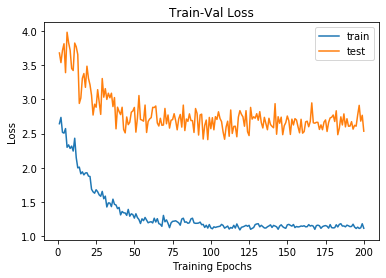

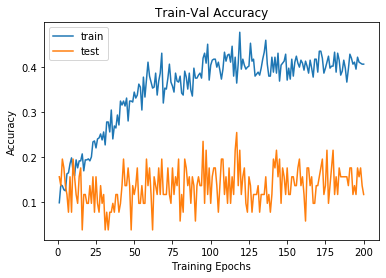

In [16]:
trainutils_compound.plot_loss(loss_hist, metric_hist)